In [2]:
from os import environ
import time
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.plot import show
from rasterio import features
from affine import Affine
import geopandas as gpd
from geopandas import GeoDataFrame
from skimage.segmentation import slic, felzenszwalb, watershed
from skimage.future import graph
from skimage.morphology import disk
from skimage.filters.rank import modal
from skimage.measure import regionprops, label
from skimage.filters import sobel
from skimage.color import rgb2gray
from sklearn import svm
from collections import OrderedDict
import matplotlib
from matplotlib import pyplot
from rasterstats import zonal_stats
import pickle

In [3]:
# from data_preparation.py as dp

def rasterize(gdf, value_column, shape, transform):
    """
    Rasterizes a GeoDataFrame
    
    Rasterizes a GeoDataFrame where the value_column becomes the pixel id.
    
    Parameters
    ----------
    gdf: GeoDataFrame
        A GeoDataFrame (i.e., vector) to rasterize.
        
    value_column: string
        A string representing the field (column) name used to create the
        raster values.
    
    shape: tuple of (rows, columns)
        The number of rows and columns of the output raster.
    
    transform: Affine transform
        An Affine Transform used to relate pixel locations to ground positions.
    
    Returns
    -------
    image: A rasterized version of the GeodataFrame in Rasterio order:
        [bands][rows][columns]
    """
    p = _geometry_value_pairs(gdf, value_column)
    image = features.rasterize(p, out_shape=shape, transform=transform)
    
    return image

In [4]:
# from data_preparation.py as dp

def vectorize(src=None, image=None, transform=None, crs=None):
    """
    Raster-to-Vector conversion.
    
    Performs a raster-to-vector conversion of a classified image. 
    
    Parameters
    ----------
    src: Rasterio datasource
        A rasterio-style datasource created using: 
            with rasterio.open('path') as src.
        The datasource referred to must be a classified image.
        This parameter is optional. If it is not provided then the 
        image and the transform must be provided. 

    image: numpy.array
        A signle band of (classified, ideally) image data where the pixel
        values are integers. Shape is (1, rows, columns). This parameter is
        optional.
    
    transform: rasterio.transform
        A raster transform used to convert row/column values to geographic
        coordinates. This parameter is optional.

    crs: rasterio.crs
        A proj4 string representing the coordinate reference system. 
        This parameter is optional.
    
    Returns
    -------
    GeoDataFrame
        A vector version of the classified raster.
    """
    if src is not None:
        img = src.read(1, masked=True)
        transform = src.transform
        crs = src.crs.to_proj4()
    else:
        img = image[0].astype(np.int32)
        
    shps = features.shapes(img, transform=transform)
    records = []

    for id, shp in enumerate(shps):
        if shp[1] != 0:
            item = {'geometry': shp[0], 'id': id+1, 'properties': 
                    OrderedDict([('dn', np.int(shp[1]))]),
                    'type': 'Feature'}
            records.append(item)

    vec = GeoDataFrame.from_features(records)
    vec.crs = crs
    return vec

In [97]:
# from data_preparation.py as dp

def add_zonal_properties(src=None, bands=[1,2,3], image=None, transform=None,
                         band_names=['blue', 'green', 'red'], stats=['mean'],
                         gdf=None):
    """
    Adds zonal properties to a GeoDataFrame.
    
    Adds zonal properties to a GeoDataFrame, where the statistics 'stats' are
    calculated for all pixels within the geographic objects boundaries.
    
    Parameters
    ----------
    src: Rasterio datasource
        A rasterio-style datasource created using: 
            with rasterio.open('path') as src.
        This parameter is optional. If it is not provided then the 
        image and the transform must be provided.
    
    bands: list of integers
        The list of bands to read from src. This parameter is optional if src
        is not provided.

    image: numpy.array
        A signle band of (classified, ideally) image data where the pixel
        values are integers. Shape is (1, rows, columns). This parameter is
        optional.
    
    transform: rasterio.transform
        A raster transform used to convert row/column values to geographic
        coordinates. This parameter is optional.
    
    band_names: list of strings
        The labels corresponding to each band of the src or image. 
    
    stats: list of strings
        The list of zonal statistics to calculate for each geographic object.
        The full list of stats is: ['sum', 'std', 'median', 'majority',
        'minority', 'unique', 'range', 'nodata', 'percentile_<q>']. Replace
        <q> with a value between 1 and 100, inclusive.
    
    gdf: GeoDataFrame
        The GeoDataFrame to be updated with zonal statistics. The number of
        columns that will be added is equal to len(bands) * len(stats). 
    
    Returns
    -------
    GeoDataFrame
        A GeoDataFrame with the zonal statistics added as new columns. 
    """
    if src is not None:
        image = src.read(bands, masked=True)
        transform = src.transform

    if len(image) != len(band_names): 
        print("The number of bands must equal the number of bands_names.")
        return None

    for band, name in enumerate(band_names):
        raster_stats = zonal_stats(gdf, image[band], stats=stats, 
                                   affine=transform)
        
        fields = [[] for i in range(len(stats))]
        labels = []
        
        for i, rs in enumerate(raster_stats):
            for j, r in enumerate(rs):
                if i == 0:
                    labels.append(r)
                fields[j].append(rs[r])
        
        for i, l in enumerate(labels):
            gdf.insert(len(gdf.columns)-1, name + "_" + l, fields[i])

    return gdf

In [6]:
def get_prop(props, label):
    for p in props:
        if p.label == label:
            return p

In [7]:
# from data_preparation.py as dp

def add_shape_properties(classified_image, gdf, attributes=['area', 'perimeter']):
    """
    Add raster properties as vector fields.
    
    POSSIBLE IMPROVEMENT!! REMOVE PARAMETER classified_image AND INSTEAD USE 
    rasterize TO RASTERIZE THE gdf. 
        
    Parameters
    ----------
    classified_image: numpy.array
        A 2D image with integer, class-based, values.
    
    gdf: GeoDataFrame
        A GeoDataFrame (vector) with object boundaries corresponding to image
        regions. Image attributes will be assigned to each vector object.
    
    attributes: list of strings
        attributes is a list of strings where each string is a type of shape to
        calculate for each polygon. Possible shapes include: area, bbox_area,
        centroid, convex_area, eccentricity, equivalent_diamter, euler_number,
        extent, filled_area, label, maxor_axis_length, max_intensity,
        mean_intensity, min_intensity, minor_axis_length, orientation,
        perimeter, or solidity.
    
    Returns
    -------
    Nothing
        Instead modifies GeoDataFrame in place.
    """
    clim = classified_image[0, :, :]
    props = regionprops(clim)
    
    attributes = {s: [] for s in attributes}

    for row in gdf.itertuples():
        rid = getattr(row, 'dn')
        
        p = get_prop(props, rid)
        if p is not None:
            for a in attributes:
                attributes[a].append(getattr(p, a))

    try:
        for a in attributes:
            if (a == 'area'):
                gdf.insert(len(gdf.columns)-1, a, gdf.geometry.area)
            elif (a == 'perimeter'):
                gdf.insert(len(gdf.columns)-1, a, gdf.geometry.length)
            else:
                gdf.insert(len(gdf.columns)-1, a, attributes[a])
    except:
        print("The geometry is bad for this gdf.")
        print(gdf.columns)
    
    return gdf

In [8]:
# from data_preparation.py as dp

def bsq_to_bip(image):
    # no error checking yet...
    return  image.transpose(1, 2, 0)


def bip_to_bsq(image):
    # no error checking yet...
    return  image.transpose(2, 0, 1)

In [9]:
def sobel_edge_detect(src=None, band=1, image=None, mask=None):
    """
    Performs a Sobel edge detection.

    Performs a Sobel edge detection on a 2D image.
    
    Parameters
    ----------
    src: Rasterio datasource
        A rasterio-style datasource created using: 
            with rasterio.open('path') as src.
        This parameter is optional. If it is not provided then image must be
        provided.
    
    band: integer
        The band to read from src. This band will be used for edge detection.

    image: numpy.array
        A rasterio-style image. The image is any single band obtained by: 
            image = src.read(band, masked=True), where band is an integer.
        This parameter is optional.
            
    mask: numpy.array
        A rasterio-style image. The image is any single band obtained by: 
            image = src.read_masks(1), where band is an integer. 
        This parameter is optional.
        
    Returns
    -------
    numpy.array
        A single band, rasterio-style image ([band][row][column]).
    """
    if src is not None:
        image = src.read(band, masked=True)
        mask = src.read_masks(1)
#         mask[mask > 0] = 1
    else:
        image = image
#         mask[mask > 255] = 1
        
    edges = sobel(image)
    return bip_to_bsq(edges[:, :, np.newaxis])

In [10]:
# from data_preparation.py as dp

def segmentation(model=None, params=None, src=None, bands=[1,2,3], image=None,
                 mask=None, modal_radius=None, sieve_size=250):
    """
    Segment the image.

    Segment the image using an algorithm from sklearn.segmentation.

    Parameters
    ----------
    model: sklearn.segmentation model
        A model from sklearn.segmentation (e.g., slic, slic0, felzenswalb)

    params: sklearn.segmentation model parameters
        The unique parameters for the selected segmentation algorithm. Will be
        passed to the model as the kwargs argument.

    src: Rasterio datasource
        A rasterio-style datasource, created using:
        with rasterio.open('path') as src.
        There must be at least 3 bands of image data. If there are more than
        3 bands, the first three will be used (see 'bands' parameter). This 
        parameter is optional. **If it is not provided, then image and transform
        must be supplied.--really?? Not any more, right?**
    
    bands: array of integers
        The array of 3 bands to read from src as the RGB image for segmentation.
        
    image: numpy.array
        A 3-band (RGB) image used for segmentation. The shape of the image
        must be ordered as follows: (bands, rows, columns).
        This parameter is optional.
    
    mask: numpy.array
        A 1-band image mask. The shape of the mask must be ordered as follows:
        (rows, columns). This parameter is optional.
    
    modal_radius: integer
        Integer representing the radius of a raster disk (i.e., circular
        roving window). Optional. If not set, no modal filter will be applied.
    
    sieve_size: integer
        An integer representing the smallest number of pixels that will be
        included as a unique segment. Segments this size or smaller will be
        merged with the neighboring segment with the most pixels. 

    Returns
    -------
    numpy.array
        A numpy array arranged as rasterio would read it (bands=1, rows, cols)
        so it's ready to be written by rasterio

    """
    if src is not None:
        img = bsq_to_bip(src.read(bands, masked=True))
        mask = src.read_masks(1)
        mask[mask > 0] = 1
    else:
        img = bsq_to_bip(image)
    
    if isinstance(model, type(watershed)):
        img = sobel(rgb2gray(img))

    output = model(img, **params).astype('int32')

    while np.ndarray.min(output) < 1:
        output += 1

    if modal_radius != None:
        output = modal(output.astype('int16'), selem=disk(modal_radius))

    output = features.sieve(output, sieve_size)
    output = label(output, connectivity=1)
    
    output = bip_to_bsq(output[:, :, np.newaxis])

    return output

In [11]:
# from skimage import data, io, segmentation, color
# from skimage.future import graph
# import numpy as np


def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])

In [12]:
%pwd

'/home/jovyan/learn_python/rag_and_zonal_statistics'

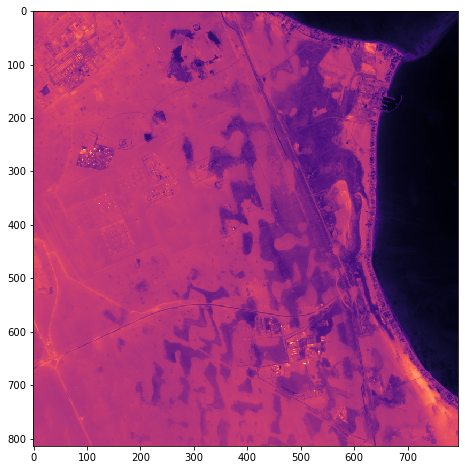

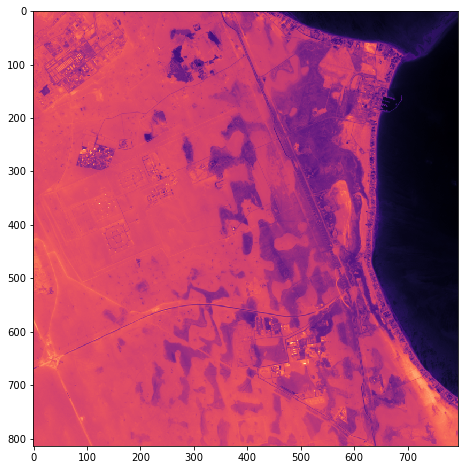

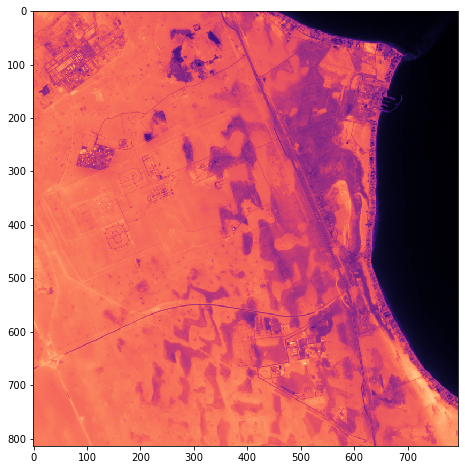

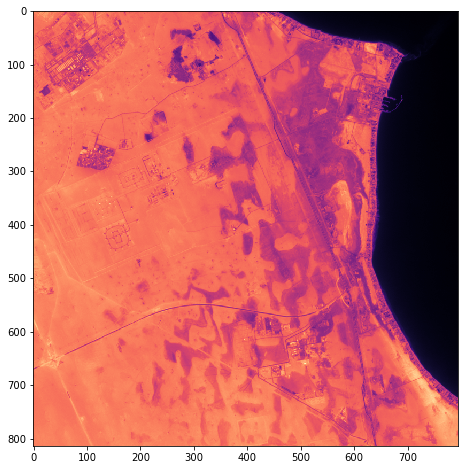

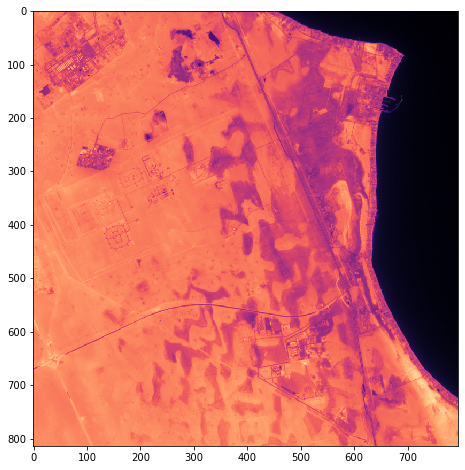

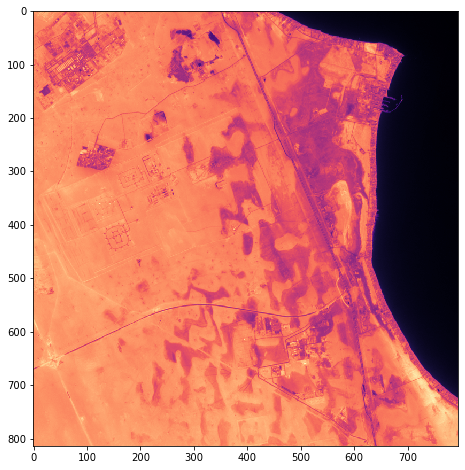

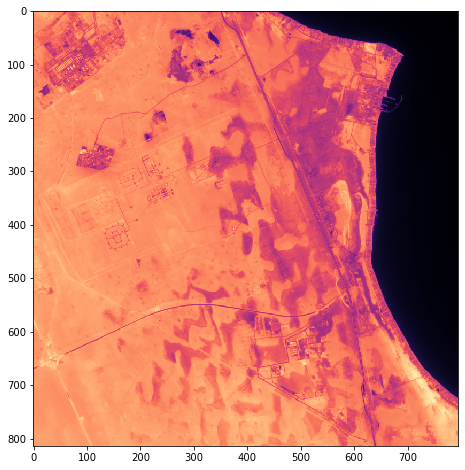

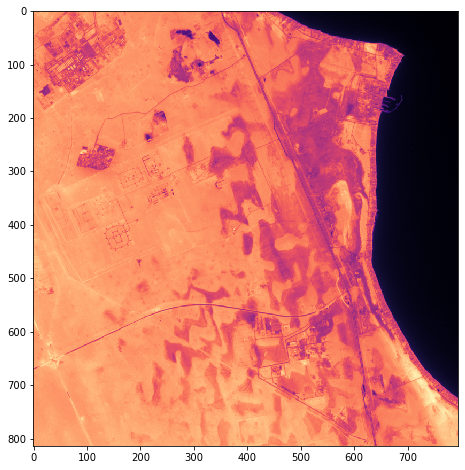

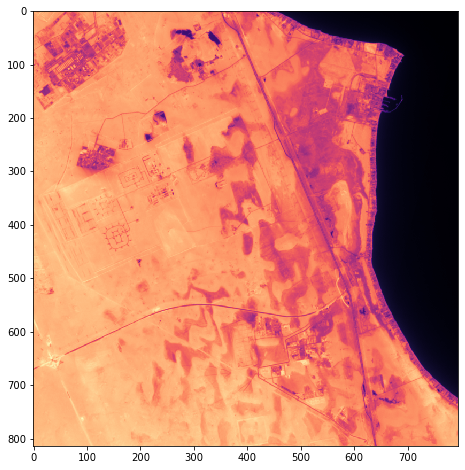

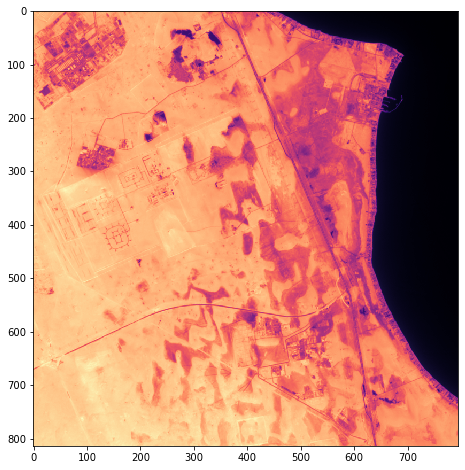

In [135]:
with rasterio.open("./images/KW_clip.tif") as src:
    slic_params = {
        'compactness': 0.01,
        'n_segments': 300,
        'multichannel': True,
        'slic_zero': True
    }
    
    felz_params = {
        'scale': 10,
        'sigma': 0.3,
        'min_size': 25
    }
    
    watershed_params = {
        'markers': 3000,
        'compactness': 0.0001
    }
    
    #my_window = Window(1750, 2000, 1024, 1024)
    #ul = src.transform*(1750, 2000)
    #t = src.transform
    #my_transform = Affine(t.a, t.b, ul[0], t.d, t.e, ul[1])

    #image = src.read([3, 4, 1])
    for i in range(1,11):
        
        image = src.read(i)
        fig, ax = pyplot.subplots(1, figsize=(8, 8))
#         ax.imshow(image, cmap='rainbow')
        show(image, cmap='magma')

In [138]:
with rasterio.open("./images/KW_clip.tif") as src:
    slic_params = {
        'compactness': 0.01,
        'n_segments': 300,
        'multichannel': True,
        'slic_zero': True
    }
    
    felz_params = {
        'scale': 1,
        'sigma': 0.1,
        'min_size': 100
    }
    
    watershed_params = {
        'markers': 3000,
        'compactness': 0.0001
    }
    
    #my_window = Window(1750, 2000, 1024, 1024)
    #ul = src.transform*(1750, 2000)
    #t = src.transform
    #my_transform = Affine(t.a, t.b, ul[0], t.d, t.e, ul[1])

    image = src.read([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])#, window=my_window)
    print(len(image))
    # Segment the image.
#     rout = segmentation(model=slic, params=slic_params, image=image, modal_radius=3)
    rout = segmentation(model=felzenszwalb, params=felz_params, image=image)
#    rout = segmentation(model=watershed, params=watershed_params, image=image)
    vout = vectorize(image=rout, transform=src.transform,
                      crs=src.crs.to_proj4())

    vout.to_file("wetlands.gpkg", layer="initialSegments", driver="GPKG")
    
    # Region Agency Graph to merge segments
    orig = bsq_to_bip(image)
    labels = (bsq_to_bip(rout))[:, :, 0]

#    rag = graph.rag_mean_color(orig, labels, mode='similarity', sigma=0.2) # or...mode='distance'
#     rout = graph.cut_normalized(labels, rag)
#     rout = graph.merge_hierarchical(labels, rag, thresh=5, rag_copy=False,
#                              in_place_merge=True,
#                              merge_func=merge_mean_color,
#                              weight_func=_weight_mean_color)

    # Vectorize the RAG segments
#    rout = bip_to_bsq(rout[:, :, np.newaxis])
    vout = vectorize(image=rout, transform=src.transform,
                     crs=src.crs.to_proj4())

    # Add spectral properties.
    vout = add_zonal_properties(image=image, transform=src.transform, 
                                bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], band_names=['blue', 'green', 'red','veg1', 'veg2', 'veg3', 'nir', 'veg4', 'swir1', 'swir2'],
                                stats=['mean'],
                                gdf=vout)

    # Add shape properties.
    vout = add_shape_properties(rout, vout, ['area', 'perimeter',
                                             'eccentricity', 
                                             'equivalent_diameter',
                                             'major_axis_length',
                                             'minor_axis_length',
                                             'orientation'])

    # Add texture properties.
    edges = sobel_edge_detect(src, band=1)
    vout = add_zonal_properties(image=edges, band_names=['sobel'],
                                stats=['mean'],
                                transform=src.transform, gdf=vout)

    vout.to_file("wetlands.gpkg", layer="ready2classify", driver="GPKG")
    
    print("All done!!")

10
All done!!
